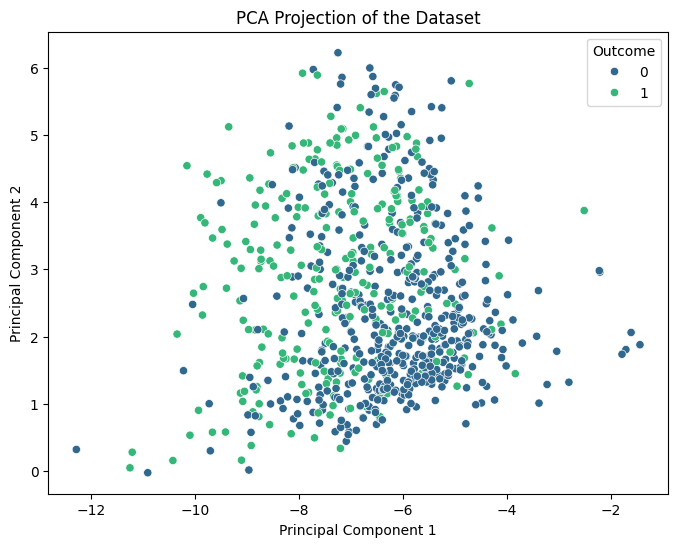

Accuracy Score: 0.7731481481481481


In [ ]:

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("Multivariate_Analysis").getOrCreate()

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
           "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
data = pd.read_csv(url, header=None, names=columns)

# Convert pandas dataframe to Spark dataframe
df = spark.createDataFrame(data)

# Assemble feature columns
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                "BMI", "DiabetesPedigreeFunction", "Age"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = vector_assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Apply PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df)
df_pca = pca_model.transform(df)

# Convert PCA results to Pandas for visualization
pca_data = df_pca.select("pca_features", "Outcome").toPandas()
pca_data[["PC1", "PC2"]] = pca_data["pca_features"].apply(lambda x: pd.Series(x.toArray()))

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data["PC1"], y=pca_data["PC2"], hue=pca_data["Outcome"], palette='viridis')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of the Dataset")
plt.show()

# Prepare training and testing data
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Outcome", maxIter=100)
lr_model = lr.fit(train_df)

# Make predictions
predictions = lr_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy Score: {accuracy}")
